In [1]:
import datarobot as dr
dr.Client(token='NjM1MGQyYWFjZTUxMmYyMDZjMDg3YzFjOmZ5dldzeExNVzBUUFJyanl4NkVvRk9nK0R3RHVMTzFQY2FGU0JwSFFpQkE9', endpoint='https://app2.datarobot.com/api/v2/')

# MultiClass

0,0 - 0 <br>
0,1 - 1 <br>
1,0 - 2 <br>
1,1 - 3

In [8]:
h1n1_training_dataset_file_path = '/Users/aakashagrawal/Desktop/MMA/869/Final Project/Data/all_data.xlsx'

# Load dataset
training_dataset = dr.Dataset.create_from_file(h1n1_training_dataset_file_path)

# Create a new project based on dataset
project = dr.Project.create_from_dataset(training_dataset.id, project_name='869 MC - v101')

In [9]:
from datarobot import AUTOPILOT_MODE

In [10]:
# Use training data to build models
# Set the project's target and initiate Autopilot (runs in Quick mode unless a different mode is specified)
project.analyze_and_model(target='target', worker_count=20)

# Open the project's Leaderboard to monitor the progress in UI.
# project.open_in_browser()

# model = project.get_top_model()

Project(869 MC - v101)

In [11]:
model = project.get_top_model()

In [12]:
model

Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping')

In [15]:
#model.get_roc_curve('validation')

In [16]:
models = project.get_models(with_metric='AUC')
models

[Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping'),
 Model('AVG Blender'),
 Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping'),
 Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping'),
 Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping'),
 Model('Light Gradient Boosted Trees Classifier with Early Stopping (SoftMax Loss) (16 leaves)'),
 Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping'),
 Model('Keras Slim Residual Neural Network Classifier using Training Schedule (1 Layer: 64 Units)'),
 Model('Light Gradient Boosted Trees Classifier with Early Stopping (SoftMax Loss) (16 leaves)'),
 Model('Keras Slim Residual Neural Network Classifier using Training Schedule (1 Layer: 64 Units)'),
 Model('Regularized Logistic Regression (L2)'),
 Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping'),
 Model('Regularized Logistic Regression (L2)'),
 Model('RandomForest Classifier (Gini)'),
 Mo

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [18]:
def matplotlib_pair_histogram(labels, counts, target_avgs, bin_count, ax1, feature):
    # Rotate categorical labels
    if feature.feature_type in ["Categorical", "Text"]:
        ax1.tick_params(axis="x", rotation=45)
    ax1.set_ylabel(feature.name, color=dr_blue)
    ax1.bar(labels, counts, color=dr_blue)
    # Instantiate a second axis that shares the same x-axis
    ax2 = ax1.twinx()
    ax2.set_ylabel(target_feature_name, color=dr_orange)
    ax2.plot(labels, target_avgs, marker="o", lw=1, color=dr_orange)
    ax1.set_facecolor(dr_dark_blue)
    title = "Histogram for {} ({} bins)".format(feature.name, bin_count)
    ax1.set_title(title)

In [19]:
def draw_feature_histogram(feature_name, bin_count, project, target_feature_name):
    feature = dr.Feature.get(project.id, feature_name)
    # Retrieve downsampled histogram data from server
    # based on desired bin count
    data = feature.get_histogram(bin_count).plot
    labels = [row["label"] for row in data]
    counts = [row["count"] for row in data]
    target_averages = [row["target"] for row in data]
    f, axarr = plt.subplots()
    f.set_size_inches((10, 4))
    matplotlib_pair_histogram(labels, counts, target_averages, bin_count, axarr, feature)

In [20]:
def plot_dr_roc_curve(project, model, source="holdout"):
    if source == "holdout":
        project.unlock_holdout()
    roc = model.get_roc_curve(source)
    df = pd.DataFrame(roc.roc_points)

    dr_dark_blue = "#08233F"
    dr_roc_green = "#03c75f"
    white = "#ffffff"
    dr_purple = "#65147D"
    dr_dense_green = "#018f4f"
    dr_blue = "#1F77B4"
    dr_orange = "#FF7F0E"
    dr_red = "#BE3C28"

    fig = plt.figure(figsize=(8, 8))
    axes = fig.add_subplot(1, 1, 1, facecolor=dr_dark_blue)

    plt.scatter(df.false_positive_rate, df.true_positive_rate, color=dr_roc_green)
    plt.plot(df.false_positive_rate, df.true_positive_rate, color=dr_roc_green)
    plt.plot([0, 1], [0, 1], color=white, alpha=0.25)
    plt.title("ROC curve")
    plt.xlabel("False Positive Rate (Fallout)")
    plt.xlim([0, 1])
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.ylim([0, 1])

In [21]:
def get_dr_confusion_matrix(project, model, source="holdout", threshold=None):
    if source == "holdout":
        project.unlock_holdout()

    roc = model.get_roc_curve(source)
    if threshold is None:
        threshold = roc.get_best_f1_threshold()
    metrics = roc.estimate_threshold(threshold)
    roc_df = pd.DataFrame(
        {
            "Predicted Negative": [
                metrics["true_negative_score"],
                metrics["false_negative_score"],
                metrics["true_negative_score"] + metrics["false_negative_score"],
            ],
            "Predicted Positive": [
                metrics["false_positive_score"],
                metrics["true_positive_score"],
                metrics["true_positive_score"] + metrics["false_positive_score"],
            ],
            "Total": [
                len(roc.negative_class_predictions),
                len(roc.positive_class_predictions),
                len(roc.negative_class_predictions) + len(roc.positive_class_predictions),
            ],
        }
    )
    roc_df.index = pd.MultiIndex.from_tuples([("Actual", "-"), ("Actual", "+"), ("Total", "")])
    roc_df.columns = pd.MultiIndex.from_tuples(
        [("Predicted", "-"), ("Predicted", "+"), ("Total", "")]
    )
    roc_df.style.set_properties(**{"text-align": "right"})
    return roc_df

In [22]:
def plot_feature_impact(model):
    feature_impacts = model.get_or_request_feature_impact()

    dr_dark_blue = "#08233F"
    dr_roc_green = "#03c75f"
    white = "#ffffff"
    dr_purple = "#65147D"
    dr_dense_green = "#018f4f"
    dr_blue = "#1F77B4"
    dr_orange = "#FF7F0E"
    dr_red = "#BE3C28"

    # Formats the ticks from a float into a percent
    percent_tick_fmt = mtick.PercentFormatter(xmax=1.0)

    impact_df = pd.DataFrame(feature_impacts)[:10]
    impact_df.sort_values(by="impactNormalized", ascending=True, inplace=True)

    # Positive values are blue, negative are red
    bar_colors = impact_df.impactNormalized.apply(lambda x: dr_red if x < 0 else dr_blue)

    ax = impact_df.plot.barh(
        x="featureName", y="impactNormalized", legend=False, color=bar_colors, figsize=(10, 14)
    )
    ax.xaxis.set_major_formatter(percent_tick_fmt)
    ax.xaxis.set_tick_params(labeltop=True)
    ax.xaxis.grid(True, alpha=0.2)
    ax.set_facecolor(dr_dark_blue)

    plt.ylabel("")
    plt.xlabel("Effect")
    plt.xlim((None, 1))  # Allow for negative impact
    plt.title("Feature Impact", y=1.04)


In [23]:
# Picking the best non-blender model based on AUC
best_model = project.get_top_model('AUC')
best_model_auc = max([m.metrics['AUC']['crossValidation'] for m in models 
                      if m.is_frozen is False 
                      and m.model_category != 'blend' 
                      and m.metrics['AUC']['crossValidation'] is not None])
best_model = [m for m in models if m.metrics['AUC']['crossValidation'] == best_model_auc][0]

In [24]:
best_model

Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping')

In [44]:
#plot_dr_roc_curve(project, model=best_model, source='holdout')

In [28]:
#roc_df = get_dr_confusion_matrix(project=project, model=best_model, source='holdout')
#roc_df

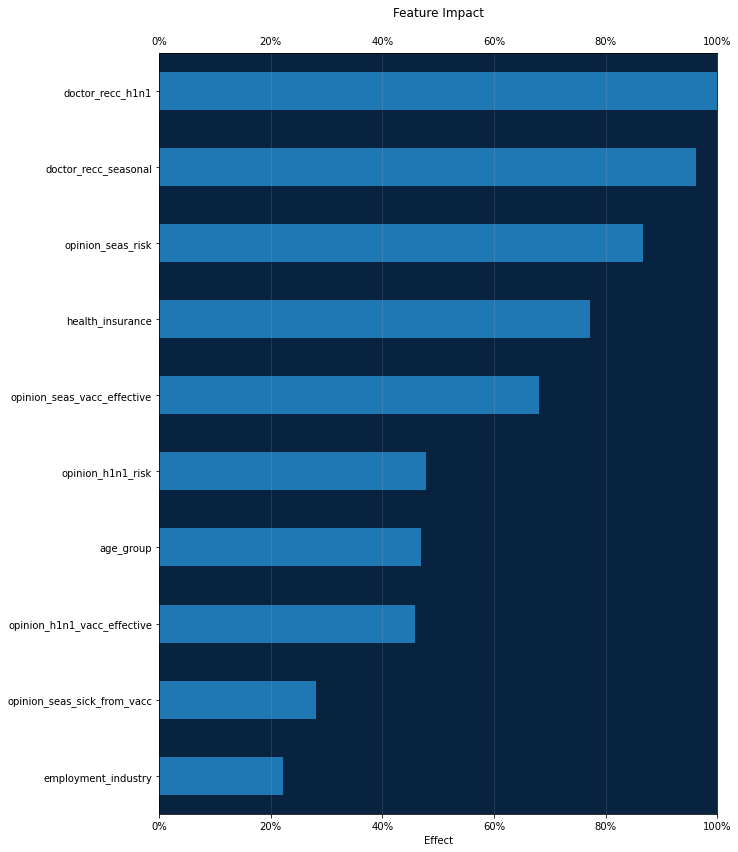

In [29]:
plot_feature_impact(model=best_model)

In [30]:
best_model

Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping')

In [31]:
test_dataset_file_path = '/Users/aakashagrawal/Desktop/MMA/869/Final Project/Data/test_set_features.csv'

In [32]:
model

Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping')

In [33]:
dataset_from_path = project.upload_dataset('/Users/aakashagrawal/Desktop/MMA/869/Final Project/Data/test_set_features.csv')

In [34]:
# Test predictions on new data
predict_job = model.request_predictions(dataset_from_path.id)
predictions = predict_job.get_result_when_complete()
predictions.head()

,row_id,prediction,"class_0,0","class_0,1","class_1,0","class_1,1"
0,0,"0,0",0.771536,0.124503,0.049981,0.053980
1,1,"0,0",0.949838,0.010868,0.034959,0.004335
2,2,"0,1",0.271868,0.530930,0.010734,0.186469
3,3,"1,1",0.102904,0.172296,0.015209,0.709591
4,4,"0,0",0.464877,0.265969,0.098246,0.170908


In [35]:
preds = pd.DataFrame()

In [36]:
preds['h1n1_vaccine']=predictions['class_1,0']+predictions['class_1,1']
preds['seasonal_vaccine'] = predictions['class_0,1']+predictions['class_1,1']

In [37]:
preds.head()

,h1n1_vaccine,seasonal_vaccine
0,0.103961,0.178483
1,0.039293,0.015203
2,0.197202,0.717399
3,0.724800,0.881887
4,0.269154,0.436877


In [38]:
preds['respondent_id'] = preds.index
preds.head()

,h1n1_vaccine,seasonal_vaccine,respondent_id
0,0.103961,0.178483,0
1,0.039293,0.015203,1
2,0.197202,0.717399,2
3,0.724800,0.881887,3
4,0.269154,0.436877,4


In [39]:
preds = preds[['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine']]
preds.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0.103961,0.178483
1,1,0.039293,0.015203
2,2,0.197202,0.717399
3,3,0.724800,0.881887
4,4,0.269154,0.436877


In [40]:
preds['respondent_id'] = preds['respondent_id']+26707
preds.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.103961,0.178483
1,26708,0.039293,0.015203
2,26709,0.197202,0.717399
3,26710,0.724800,0.881887
4,26711,0.269154,0.436877


In [42]:
preds.to_csv('v101.csv',index=False)